# Fuzzy Inference System for Psychological Attention
In this notebook, the code for the fuzzy inference system work done by Juan
Sebastián Cárdenas can be seen. The code was tested with `Julia 1.4.2`.

## Installation Packages
In the next cell, the fork made jointly by Juan Sebastián Cárdenas and David
Plazas of the `Fuzzy.jl` package can be found. Furthermore, the `Plots` package
is also installed as it is needed to show the figures.


In [ ]:
Pkg.add(https://github.com/juanscr/Fuzzy.jl)
Pkg.add(Plots)


## Package imports
Furthermore, the figures are shown by default using the last command.

In [1]:
using Fuzzy
using Plots

default(show = true)


## Generic Functions

The `view` function plots the input and outputs of a FIS.
- `domain` is the discourse universe for the variable
- `input` is a dictionary that contains the categorical values and their
  memebership functions
- `pos` dictates the position of the legend

In [2]:
function view(domain :: Vector{Float64}, input :: Dict{String, Fuzzy.MF}, pos :: Symbol)
    evals = map(x0 -> x0.eval, values(input))
    labels = permutedims(collect(keys(input)))
    colors = [:red :black :blue]
    return plot(domain, evals, label = labels, legend = pos, color = colors)
end;


The `ComplementMF` object represents the membership function of the complement
of another membership function. This object has the same attributes as the MF
objects have, with the addition of the `compMF` object with represents the
membership function which the complement is being extracted.


In [3]:
mutable struct ComplementMF<:Fuzzy.MF
    compMF::Fuzzy.MF

    eval::Function
	mean_at::Function
	get_n::Function
	cut::Function

    function ComplementMF(compMF)
        this = new()

        this.compMF = compMF

        this.eval = function(x)
            return 1 - this.compMF.eval(x)
        end

        this.mean_at = function(firing_strength)
            return 1 - this.compMF.mean_at(firing_strength)
        end

        this.get_n = function(tol)
            return this.compMF.get_n(tol)
        end

        this.cut = function(α)
            return this.compMF.cut(1 - α)
        end

        this
    end
end;


The `add_not` function adds to the input dictionary the complement of a
category.
- `input` is the dictionary which contains the categorical values and membership
  functions
- `value` is the categorical value for which the complement will be calculated


In [4]:
function add_not(input, value)
    push!(input, string("Not ", value) => ComplementMF(input[value]))
end;


## Fuzzy Inference System
In this section, the fuzzy inference system definitions and graphs can be found.

### Inputs
In this cell, the level of attention variable is defined.


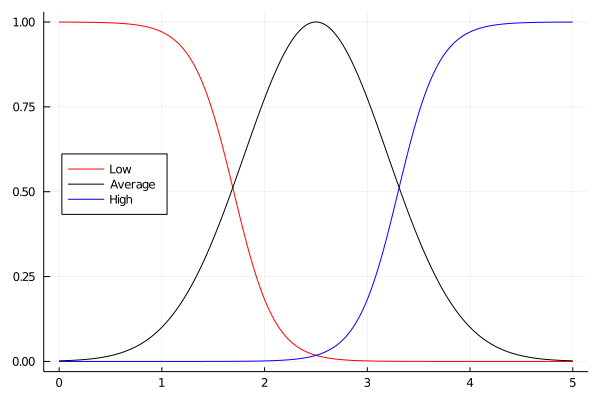

In [5]:
# Discourse univrerse of level of attention
domain_att = Array{Float64, 1}(range(0, 5, length = 1000))

# Categorical values
input_att = Dict{String, Fuzzy.MF}("Low" => SigmoidMF(-5, 1.7, 0),
                                  "Average" => GaussianMF(2.5, 0.7),
                                  "High" => SigmoidMF(5, 3.3, 5))

view(domain_att, input_att, :left)

In this cell, the academic performance variable is defined.


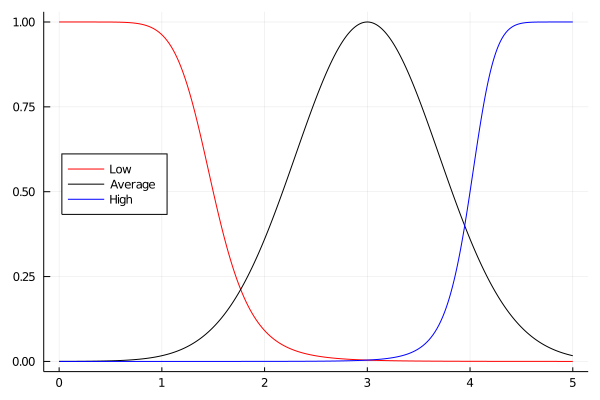

In [6]:
# Discourse univrerse of academic performance
domain_ap = Array{Float64, 1}(range(0, 5, length = 1000))

# Categorical values
input_ap = Dict{String, Fuzzy.MF}("Low" => BellMF(1.5, 4, 0),
                                  "Average" => GaussianMF(3, 0.7),
                                  "High" => BellMF(1, 4, 5))

view(domain_ap, input_ap, :left)


In this cell, the emotional socialization variable is defined.


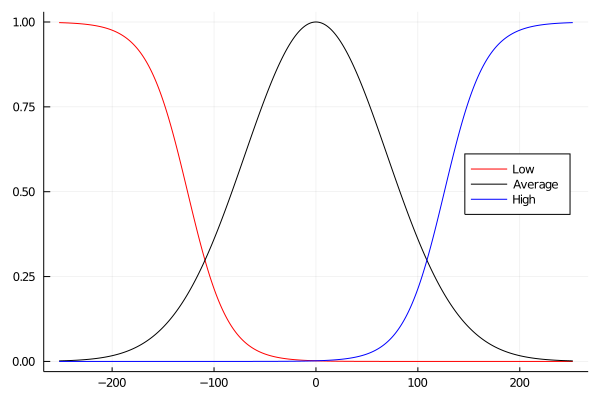

In [7]:
# Discourse universe of emotional socialization
domain_es = Array{Float64, 1}(range(-252, 252, length = 1000))

# Categorical values
input_es = Dict{String, Fuzzy.MF}("Low" => SigmoidMF(-0.05, -126, -252),
                                  "Average" => GaussianMF(0, 70),
                                  "High" => SigmoidMF(0.05, 126, 252))

view(domain_es, input_es, :right)

### Outputs
In this cell, the discourse universe and membership functions of the output
variables is defined. As every output has the same behavior, only one is
defined.


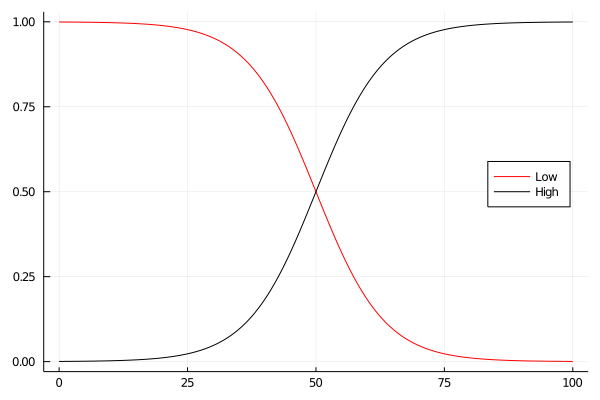

In [8]:
# Outputs
domain_output = Vector{Float64}(range(0, 100, length = 1000))
output_mf = Dict{String, Fuzzy.MF}("Low" => SigmoidMF(-0.15, 50, 0),
                                   "High" => SigmoidMF(0.15, 50, 100))

view(domain_output, output_mf, :right)


### Rules
In this section, the rules for the FIS is defined. As they were not hardcoded,
they were read from a `org` mode file that contained my personal notes. This
file is also sended.

The `read_rules` function reads the rules directly from my notes, contained in a
org mode file.
- The `number_of_outputs` gives the number of outputs that the FIS has.
- The `directory` is the relative or absolute path to the notes.org file.
- The `norm` parameter is the desired T-norm to use for the rules.


In [9]:
function read_rules(number_of_outputs :: Int64, directory :: String, norm = "MIN")
    # Open org mode file
    file = read(open(directory, "r"), String)
    file_sp = split(file, "**")

    # Find string with rules
    rules_s = Nothing
    for section in file_sp
        if section[2:6] == "Rules"
            rules_s = section
            break
        end
    end

    # Separate all rules
    rules = split(replace(rules_s, " Rules\n" => ""), "\n\n")

    # Create output list
    outputs = []
    for i in 1:number_of_outputs
        push!(outputs, [])
    end

    # Process each rule
    possibilities = r"(not )?(low|medium|high)"
    for rule in rules
        if (rule[1:2] != "If")
            return outputs
        end
        inputs = []

        aux = split(rule, " is ")
        for i in 2:(length(aux) - number_of_outputs)
            match0 = match(possibilities, aux[i]).match
            if match0 == "low"
                match0 = "Low"
            elseif match0 == "medium"
                match0 = "Average"
            elseif match0 == "not low"
                match0 = "Not Low"
            elseif match0 == "not high"
                match0 = "Not High"
            else
                match0 = "High"
            end
            push!(inputs, match0)
        end

        for i in (length(aux) - number_of_outputs + 1):length(aux)
            match0 = match(possibilities, aux[i]).match
            if match0 == "low"
                match0 = "Low"
            elseif match0 == "medium"
                match0 = "Average"
            else
                match0 = "High"
            end
            push!(outputs[i + number_of_outputs - length(aux)], Rule(inputs, match0, norm))
        end
    end

    return outputs
end;


This cell reads the rules from my notes file. Just change the variable
`directory_notes` to the path on your desktop to the notes.org file.


In [11]:
# Rule generation
directory_notes = "notes/notes.org"
rules = read_rules(3, directory_notes);


The negation for some needed categories is inserted to the respective inputs.


In [12]:
# Add not rules
add_not(input_ap, "High")
add_not(input_ap, "Low")
add_not(input_es, "Low");


In this cell, the fuzzy inference system is created given the rules.


In [13]:
# FIS creation
inputs = [input_att, input_ap, input_es]

# Depression
fis_dp = FISMamdani(inputs, output_mf, rules[1], (0, 100));

# Anxiety
fis_an = FISMamdani(inputs, output_mf, rules[2], (0, 100));

# Hyperactivity
fis_hy = FISMamdani(inputs, output_mf, rules[3], (0, 100));


## Experiments Defuzzification
In this section, the experiments done with the different defuzzification methods
can be found.

In this cell, the graph for the weighted average with fixed socialization value
can be found. For more graphs, modify the value of the `fixed_soc` to change the
fixed socialization value.


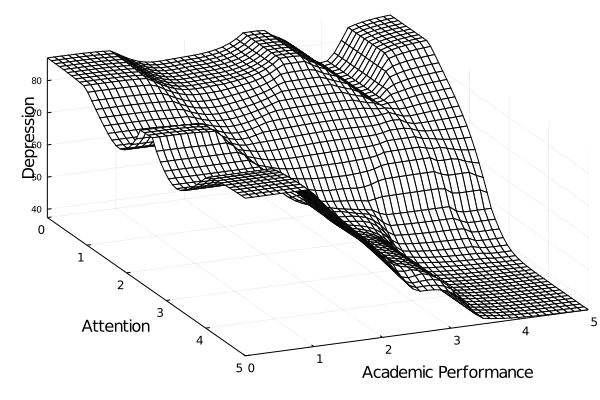

In [15]:
# Fixed socialization value
fixed_soc = -200

# Plotting
f(x, y) = eval_fis(fis_dp, [x, y, fixed_soc])
plot(collect(range(0, 5, length = 50)), collect(range(0, 5, length = 50)), f,
     st = :wireframe,
     xlabel = "Attention",
     ylabel = "Academic Performance",
     zlabel = "Depression",
     camera = (60, 60),
     ztickfont = 6)


In this cell the experiment realized with mean of maximum defuzzification method
can be found.


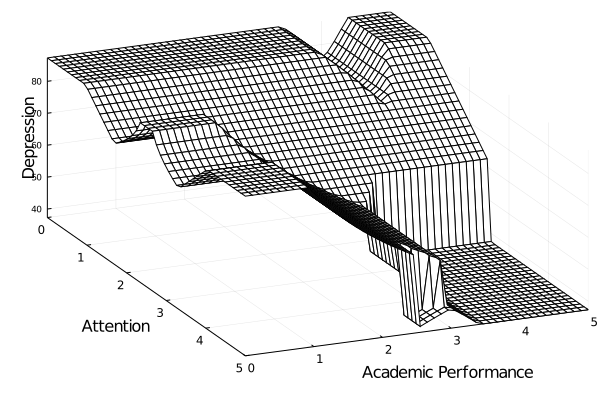

In [20]:
# Plotting
f(x, y) = eval_fis(fis_dp, [x, y, fixed_soc], "MOM")
plot(collect(range(0, 5, length = 50)), collect(range(0, 5, length = 50)), f,
     st = :wireframe,
     xlabel = "Attention",
     ylabel = "Academic Performance",
     zlabel = "Depression",
     camera = (60, 60),
     ztickfont = 6)


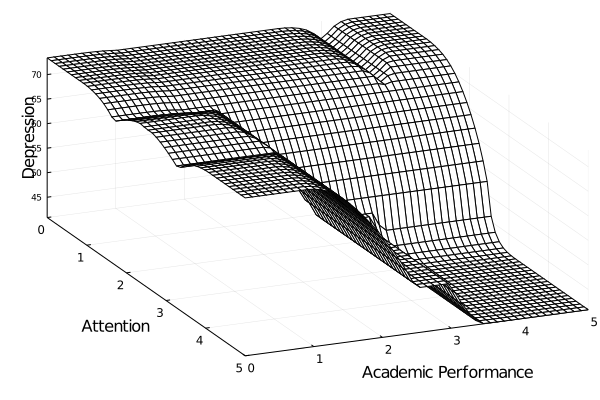

In [29]:
f(x, y) = eval_fis(fis_dp, [x, y, fixed_soc], "COG")
plot(collect(range(0, 5, length = 50)), collect(range(0, 5, length = 50)), f,
     st = :wireframe,
     xlabel = "Attention",
     ylabel = "Academic Performance",
     zlabel = "Depression",
     camera = (60, 60),
     ztickfont = 6)


## Experiments T-Norm
In this section, the experiments realized with the two T-norms can be found.

To change the selected T-norm, just modify the variable `other_t_norm` to the
desired one.


In [23]:
other_t_norm = "A-PROD"

rules0 = read_rules(3, "notes/notes.org", other_t_norm);


In this cell, the FIS for the anxiety output with the `other_t_norm` setting can
be found.


In [24]:
# Anxiety
fis_an0 = FISMamdani(inputs, output_mf, rules0[2], (0, 100));


In this cell, the experiment for the other selected T-norm can be found with a
fixed academic performance.

To change this fix value, modify the `fixed_ap` variable.

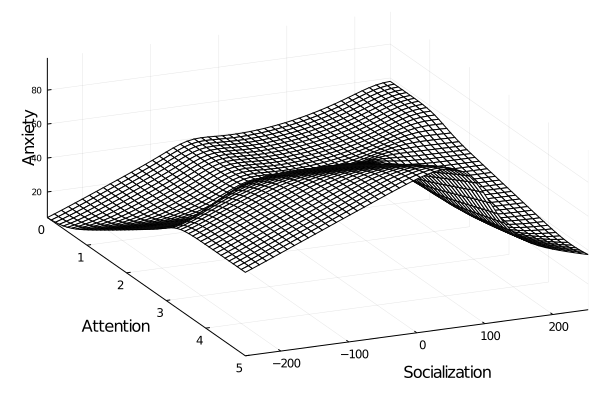

In [28]:
# Fixed academic performance
fixed_ap = 5

# Plotting
f(x, y) = eval_fis(fis_an0, [x, fixed_ap, y])
plot(collect(range(0, 5, length = 50)), collect(range(-252, 252, length = 50)), f,
     st = :wireframe,
     xlabel = "Attention",
     ylabel = "Socialization",
     zlabel = "Anxiety",
     camera = (60, 60),
     ztickfont = 6)


In this cell, the experiment for the minimum T-norm can be found with a fixed
academic performance.


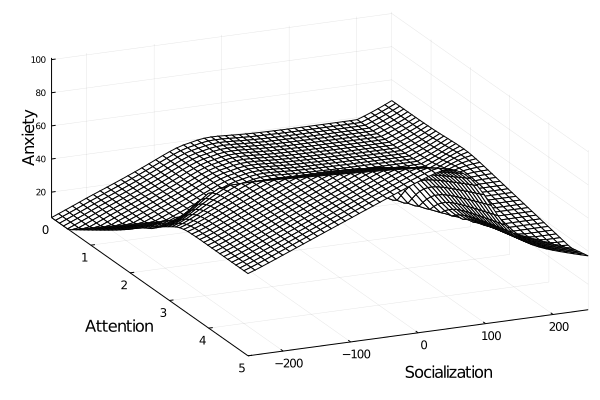

In [27]:
# Plotting
f(x, y) = eval_fis(fis_an, [x, fixed_ap, y])
plot(collect(range(0, 5, length = 50)), collect(range(-252, 252, length = 50)), f,
     st = :wireframe,
     xlabel = "Attention",
     ylabel = "Socialization",
     zlabel = "Anxiety",
     camera = (60, 60),
     ztickfont = 6)
